<a href="https://colab.research.google.com/github/albivaltzew/chips_defects/blob/main/chips_unet_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


https://kiansoon.medium.com/semantic-segmentation-is-the-task-of-partitioning-an-image-into-multiple-segments-based-on-the-356a5582370e

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="s4LVsOalgoAGfrFehLUx")
project = rf.workspace("electropriborchips").project("chip-defect-detections-separated")
dataset = project.version(4).download("png-mask-semantic")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstal

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to chip-defect-detections-separated-4 in png-mask-semantic:: 100%|██████████| 4080/4080 [00:00<00:00, 4424.97it/s]


In [ ]:
# Change to my working directory
# !cd /gdrive/MyDrive

In [ ]:
# !pip install tensorflow==2.10

In [ ]:
import os
import cv2
import keras
import numpy as np
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import random


from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

Tensorflow ver. 2.15.0


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
!nvidia-smi

Sat Jan  6 07:47:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0              28W /  70W |    103MiB / 15360MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import tensorflow as tf
visible_devices = tf.config.get_visible_devices()
for devices in visible_devices:
  print(devices)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
# Input image size that we are going to use
IMAGE_SIZE = 224
# ADE20k has 151 classes (background + 150 object)
num_classes = 11
# Set batch size
batch = 2
# Set learning rate
LR = 1e-4
# Set epoch
EPOCHS = 5

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Set your paths
input_folder = "/content/chip-defect-detections-separated-4/train"


os.makedirs("/content/data", exist_ok=True)
data_folder = "/content/data"

images_folder = os.path.join(data_folder, 'images')
os.makedirs(images_folder, exist_ok=True)

os.makedirs(os.path.join(images_folder, 'training'), exist_ok=True)
os.makedirs(os.path.join(images_folder, 'validation'), exist_ok=True)


annotations_folder = os.path.join(data_folder, 'annotations')
os.makedirs(annotations_folder, exist_ok=True)

os.makedirs(os.path.join(annotations_folder, 'training'), exist_ok=True)
os.makedirs(os.path.join(annotations_folder, 'validation'), exist_ok=True)


# List all image and mask files
image_files = [f for f in os.listdir(input_folder) if f.endswith('.jpg')]
mask_files = [f for f in os.listdir(input_folder) if f.endswith('.png')]

len(image_files), len(mask_files)

(2038, 2038)

In [ ]:
common_files = set(f.replace('_mask.png', '') for f in mask_files) & set(f.replace('.jpg', '') for f in image_files)

len(common_files)

2038

In [ ]:
train_files, val_files = train_test_split(list(common_files), test_size=0.2, random_state=42)


In [ ]:
# Move files to the corresponding folders
for file in train_files:
    shutil.move(os.path.join(input_folder, file + '.jpg'), os.path.join(images_folder, 'training', file + '.jpg'))
    shutil.move(os.path.join(input_folder, file + '_mask.png'), os.path.join(annotations_folder, 'training', file + '_mask.png'))

for file in val_files:
    shutil.move(os.path.join(input_folder, file + '.jpg'), os.path.join(images_folder, 'validation', file + '.jpg'))
    shutil.move(os.path.join(input_folder, file + '_mask.png'), os.path.join(annotations_folder, 'validation', file + '_mask.png'))

In [ ]:
# Set image and mask paths
image_path = "/content/data/images/"
mask_path = "/content/data/annotations/"
training_data = "training/"
val_data = "validation/"

In [ ]:
# Function to create lists of paths for training, validation and testing data
def load_data():

  TRAIN_X = sorted(glob(os.path.join(image_path + training_data, "*.jpg")))
  train_x = TRAIN_X[:5000]

  TRAIN_Y = sorted(glob(os.path.join(mask_path + training_data, "*.png")))
  train_y = TRAIN_Y[:5000]

  VALID_TEST_X = sorted(glob(os.path.join(image_path + val_data, "*.jpg")))
  valid_x = VALID_TEST_X[:300]

  VALID_TEST_Y = sorted(glob(os.path.join(mask_path + val_data, "*.png")))
  valid_y = VALID_TEST_Y[:300]

  test_x = VALID_TEST_X[300:600]
  test_y = VALID_TEST_Y[300:600]

  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data()

print("Training data: ", len(train_x), len(train_y))
print("Validation data: ", len(valid_x), len(valid_y))
print("Test data: ", len(test_x), len(test_y))

Training data:  1630 1630
Validation data:  300 300
Test data:  108 108


In [ ]:
# # Set image augmentation (to be called by tensorflow dataset later)
# data_augmentation = tf.keras.Sequential([
#   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#   layers.experimental.preprocessing.RandomRotation(0.2),
#   layers.experimental.preprocessing.RandomZoom(.5, .2),
#   layers.experimental.preprocessing.RandomContrast(0.1)],
#   )

In [ ]:
# Functions to read image and mask paths to output numpy arrays
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    return x

In [ ]:
# Function to generate tensorflow dataset
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.uint8])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

num_threads = 4

def tf_dataset_train(x, y, batch=batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    #dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(1)
    return dataset


def tf_dataset_valid(x, y, batch=batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(1)
    return dataset

In [ ]:
train_dataset = tf_dataset_train(train_x, train_y)
valid_dataset = tf_dataset_valid(valid_x, valid_y)
test_dataset = tf_dataset_valid(test_x, test_y)

In [ ]:
# Function to load image/mask and convert colour space from BGR to RGB so that image/mask can be displayed correctly by matplotlib
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


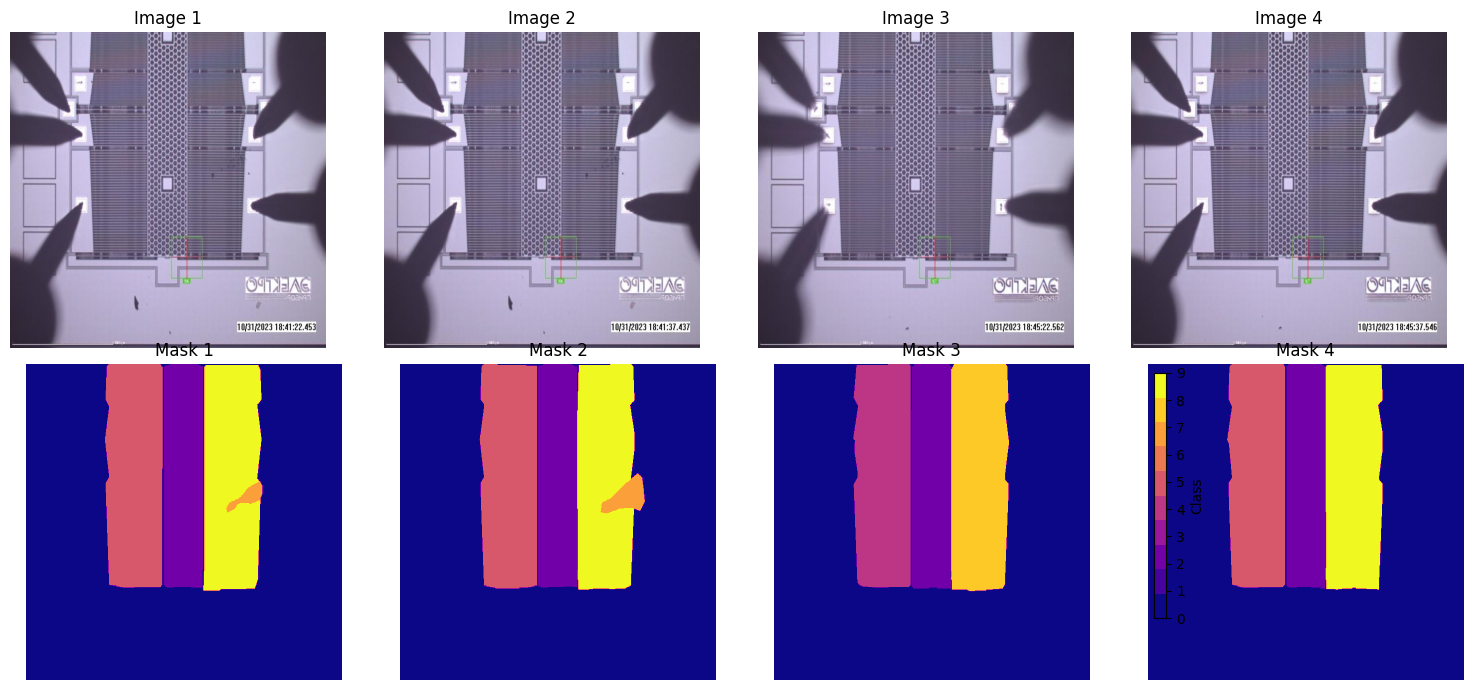

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

# Plot samples of images and corresponding masks
fig, axes = plt.subplots(2, 4, figsize=(15, 7))

for i in range(4):
    # Read and plot images
    img_path = train_x[i]
    img = read_and_rgb(img_path)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Image {i+1}')
    axes[0, i].axis('off')

    # Read and plot masks with a custom colormap
    mask_path = train_y[i]
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    cmap = plt.get_cmap('plasma', 10)  # Assuming 10 classes
    imgplot = axes[1, i].imshow(mask, cmap=cmap, vmin=0, vmax=9)
    axes[1, i].set_title(f'Mask {i+1}')
    axes[1, i].axis('off')

# Add a colorbar for the masks
cbar = plt.colorbar(imgplot, ax=axes[1, :], ticks=np.arange(10))
cbar.set_label('Class')

plt.tight_layout()
plt.show()


In [ ]:
# Function for conv2d_block (to be used for building decoder of unet)
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [ ]:
# Function for unet model creation
def unet(n_filters = 16, batchnorm = True, dropout = 0.1, num_classes=152):

    # Contracting Path (encoder)
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    encoder = MobileNetV2(input_tensor=inputs, include_top=False)

    BASE_WEIGHT_PATH = ('https://github.com/fchollet/deep-learning-models/releases/download/v0.6/')
    model_name = 'mobilenet_%s_%d_tf_no_top.h5' % ('1_0', 224)
    weight_path = BASE_WEIGHT_PATH + model_name
    weights_path = keras.utils.get_file(model_name, weight_path)
    encoder.load_weights(weights_path, by_name=True, skip_mismatch=True)

    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    x = encoder_output
    x_skip_1 = encoder.get_layer(skip_connection_names[-1]).output # 224x224
    x_skip_2 = encoder.get_layer(skip_connection_names[-2]).output # 112x112
    x_skip_3 = encoder.get_layer(skip_connection_names[-3]).output # 56x56
    x_skip_4 = encoder.get_layer(skip_connection_names[-4]).output # 28x28


    # Expansive Path (decoder)
    u6 = Conv2DTranspose(n_filters * 13, (3, 3), strides = (2, 2), padding = 'same')(x)
    u6 = concatenate([u6, x_skip_1])
    c6 = conv2d_block(u6, n_filters * 13, kernel_size = 3, batchnorm = batchnorm)
    p6 = Dropout(dropout)(c6)

    u7 = Conv2DTranspose(n_filters * 12, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, x_skip_2])
    c7 = conv2d_block(u7, n_filters * 12, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c7)

    u8 = Conv2DTranspose(n_filters * 11, (3, 3), strides = (2, 2), padding = 'same')(p7)
    u8 = concatenate([u8, x_skip_3])
    c8 = conv2d_block(u8, n_filters * 11, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c8)

    u9 = Conv2DTranspose(n_filters * 10, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, x_skip_4])
    c9 = conv2d_block(u9, n_filters * 10, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
model = unet(n_filters = 16, batchnorm = True, dropout = 0.1, num_classes=num_classes)

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# Specify all the encoder layers in a list
encoder_layers = model.layers[0:-22]

In [ ]:
# Freeze the encoder layers for transfer learning (so that weights are only changed for the decoder layers druing training)
for layer in encoder_layers:
    layer.trainable = False
    print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7c8ed0f2bc10> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c8ed34b7d00> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7c8ed33fcc40> False
<keras.src.layers.activation.relu.ReLU object at 0x7c8ed3734ac0> False
<keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7c8ed3736ce0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7c8ede18d030> False
<keras.src.layers.activation.relu.ReLU object at 0x7c8ede18d480> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c8ede18d960> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7c8ede18ebf0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c8ede18c6a0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7c8ede18ee30> False
<keras.src.layers.activation.relu.ReLU obj

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_image[0][0]']         
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
from tensorflow.keras.metrics import MeanIoU


iou_metric_instance = MeanIoU(num_classes=num_classes)


def iou(y_true, y_pred):
    # Apply softmax if your model does not have a softmax layer
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.expand_dims(y_pred, axis=-1)

    # Update the state of the iou_metric
    iou_metric_instance.update_state(y_true, y_pred)
    return iou_metric_instance.result()


# Set up loss function, optimizer, and compile the model
opt = tf.keras.optimizers.legacy.Adam(learning_rate=LR)

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', iou])


In [ ]:
# Set up early stopping and reduce learning rate on plateau
# early_stopping = EarlyStopping(
#     monitor='val_accuracy',
#     patience=3,
#     mode='max'
# )

# reduce_lr = ReduceLROnPlateau(
#     monitor='val_accuracy',
#     factor=0.2,
#     patience=2,
#     min_lr=0.00001,
# )

early_stopping_iou = EarlyStopping(
    monitor='val_iou',  # Use the monitored metric (IoU)
    patience=3,
    mode='max',  # Consider increasing IoU as improvement
)

reduce_lr_iou = ReduceLROnPlateau(
    monitor='val_iou',
    factor=0.2,
    patience=2,
    min_lr=0.00001,
)


In [ ]:
os.makedirs("/content/gdrive/MyDrive/checkpoint_iou_100", exist_ok=True)

In [ ]:
# Set up checkpoint for saving model architecture and weights
checkpoint_filepath = '/content/gdrive/MyDrive/checkpoint_iou_100'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_iou',
    mode='max',
    save_best_only=True)

In [ ]:
# Commencement of training
train_steps = len(train_x)//batch
valid_steps = len(valid_x)//batch

if len(train_x) % batch != 0:
    train_steps += 1
if len(valid_x) % batch != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs=100,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=[model_checkpoint_callback, early_stopping_iou, reduce_lr_iou]
)


Epoch 1/100


"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?


815/815 [==============================] - 119s 131ms/step - loss: 0.2502 - accuracy: 0.9171 - iou: 0.3241 - val_loss: 0.1666 - val_accuracy: 0.9545 - val_iou: 0.4256 - lr: 1.0000e-04
Epoch 2/100
815/815 [==============================] - 101s 124ms/step - loss: 0.0890 - accuracy: 0.9777 - iou: 0.4652 - val_loss: 0.1376 - val_accuracy: 0.9715 - val_iou: 0.5003 - lr: 1.0000e-04
Epoch 3/100
815/815 [==============================] - 100s 123ms/step - loss: 0.0773 - accuracy: 0.9810 - iou: 0.5192 - val_loss: 0.1106 - val_accuracy: 0.9768 - val_iou: 0.5367 - lr: 1.0000e-04
Epoch 4/100
815/815 [==============================] - 101s 123ms/step - loss: 0.0612 - accuracy: 0.9850 - iou: 0.5528 - val_loss: 0.0982 - val_accuracy: 0.9796 - val_iou: 0.5658 - lr: 2.0000e-05
Epoch 5/100
815/815 [==============================] - 100s 123ms/step - loss: 0.0593 - accuracy: 0.9854 - iou: 0.5749 - val_loss: 0.0986 - val_accuracy: 0.9794 - val_iou: 0.5841 - lr: 2.0000e-05
Epoch 6/100
815/815 [===========

1/1 [==============================] - 0s 79ms/step


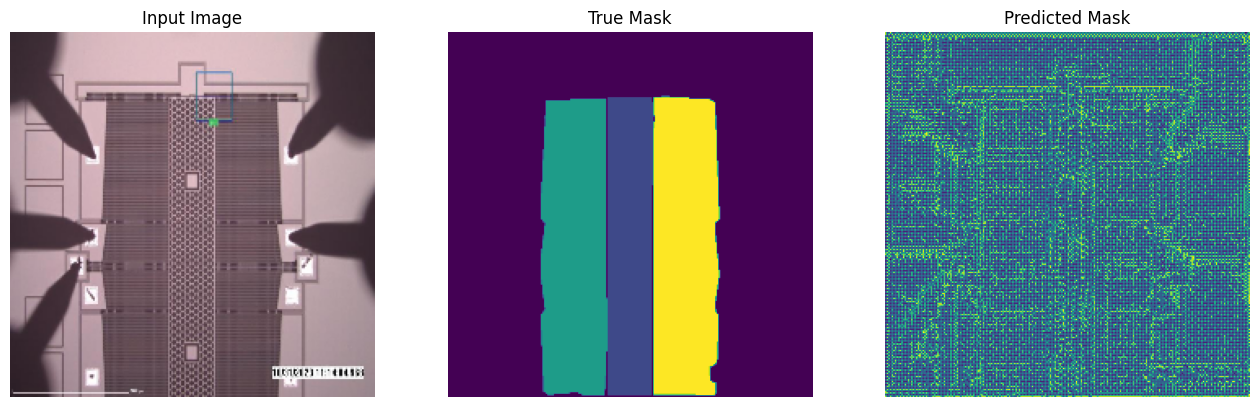

In [ ]:

def display_sample(display_list):
    plt.figure(figsize=(16, 16))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

def show_predictions():
    one_img = sample_image[0][tf.newaxis, ...]
    prediction = model.predict(one_img)
    pred_mask = create_mask(prediction)
    display_sample([sample_image[0], sample_mask[0], pred_mask[0]])

for image, mask in test_dataset.take(random.randint(1, 100)):
    sample_image, sample_mask = image, mask

show_predictions()

evaluate model

In [ ]:
test_steps = len(test_x)//batch
if len(test_x) % batch != 0:
    test_steps += 1

result = model.evaluate(test_dataset, steps=test_steps)
dict(zip(model.metrics_names, result))

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?


54/54 [==============================] - 3s 35ms/step - loss: 0.0511 - accuracy: 0.9814 - iou: 0.6900


{'loss': 0.05110810324549675,
 'accuracy': 0.9813798069953918,
 'iou': 0.6900212168693542}

Inference with loaded model

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


(224, 224, 3)
1/1 [==============================] - 1s 738ms/step


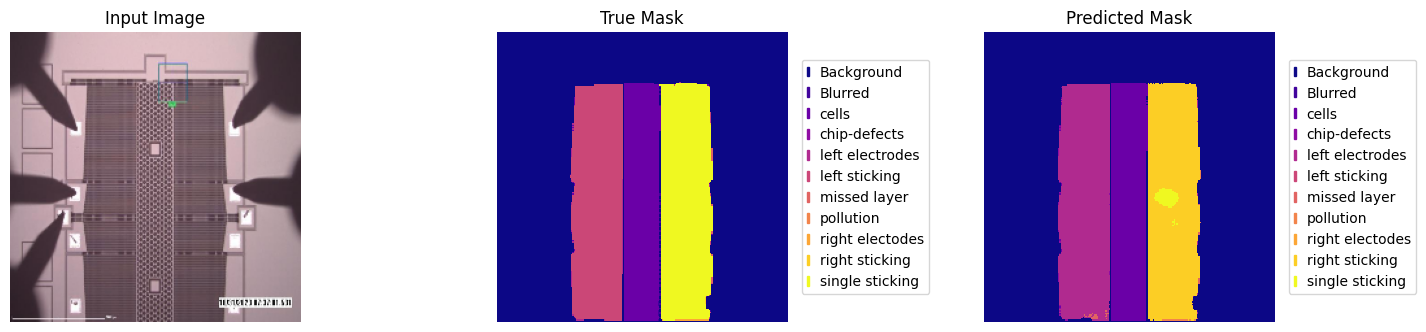

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

# Path to the directory where the saved model is located
saved_model_path = '/content/gdrive/MyDrive/checkpoint_iou_100/'

iou_metric_instance = MeanIoU(num_classes=num_classes)


def iou(y_true, y_pred):
    # Apply softmax if your model does not have a softmax layer
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.expand_dims(y_pred, axis=-1)

    # Update the state of the iou_metric
    iou_metric_instance.update_state(y_true, y_pred)
    return iou_metric_instance.result()

# Load the model
model = tf.keras.models.load_model(saved_model_path,
                                   custom_objects={'iou': iou})

class_names = ['Background',
               'Blurred',
               'cells',
               'chip-defects',
               'left electrodes',
               'left sticking',
               'missed layer',
               'pollution',
               'right electodes',
               'right sticking',
               'single sticking',]

# Create a legend showing class names with their corresponding colors
def create_legend(class_names, cmap, discrete_cmap):
    patches = [mpatches.Patch(color=cmap(i / (num_classes - 1)), label=class_names[i]) for i in range(num_classes)]
    # plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, handlelength=0.1, borderaxespad=0.)
    legend = plt.legend(handles=patches, bbox_to_anchor=(1.05, 0.5), loc='center left', handlelength=0.1, borderaxespad=0.)
    # Adjust the figure layout to accommodate the legend
    plt.tight_layout(rect=[0, 0, 0.9, 1])

# Get a colormap from matplotlib
cmap = plt.cm.get_cmap('plasma', len(class_names))

# Create a new ListedColormap using the colors from the chosen colormap
discrete_cmap = ListedColormap([cmap(i) for i in range(num_classes)])


def display_sample(display_list, class_names, cmap, num_classes):
    plt.figure(figsize=(16, 16))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.subplots_adjust(hspace=5)  # Adjust the value (e.g., hspace=0.5) to set the desired vertical space

        plt.title(title[i])

        if title[i] in ['True Mask', 'Predicted Mask']:
            plt.imshow(display_list[i], cmap=cmap, interpolation='nearest')
            # plt.colorbar(boundaries=np.arange(num_classes+1)-0.5,
            #              ticks=np.arange(num_classes),
            #              shrink=0.2,
            #              values=np.arange(num_classes))
            create_legend(class_names, cmap, num_classes)
        else:
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))

        plt.axis('off')

    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

# Function to display predictions using the loaded model
def show_predictions(dataset):
    for image, mask in dataset.take(1):  # Take one example from the dataset
        sample_image, sample_mask = image, mask
        print(sample_image[0].shape)
    one_img = sample_image[0][tf.newaxis, ...]
    prediction = model.predict(one_img)
    pred_mask = create_mask(prediction)
    display_sample([sample_image[0], sample_mask[0], pred_mask[0]], class_names, discrete_cmap, num_classes)

# Display predictions for one sample from the dataset
show_predictions(test_dataset)